# Anomaly Detection and Medication Clustering Notebook
In this notebook we'll first leverage an Isolation Forest to identify the inventory KPIs which are most informative when detecting anomalies. We'll then leverage a separate Isolation Forest to identify anomalous medications based upon their medication-level inventory KPIs. After doing so, we'll use a KMeans model to cluster medications by their various demand signals.

## Setup and Data Loading:
### Import Libraries
To further process our inventory-level dataset, we'll leverage scikit-learn to help with:
*   Feature scaling
*   Dimensionality reduction using principal component analysis (PCA)
*   Deploying the Isolation Forest model
*   Deploying the KMeans model and evaluating it using a silhouette score

In [1]:
# Load black to help with notebook formatting
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

pd.set_option("display.max_columns", None)

<IPython.core.display.Javascript object>

### Import Data

In [3]:
df_raw = pd.read_csv("../outputs/inventory_summary_statistics_wo_anomalies.csv")

<IPython.core.display.Javascript object>

In [4]:
summary_df = df_raw.copy()
summary_df.set_index("cleaned_med_id", drop=True, inplace=True)
summary_df.describe()

,inv_min,inv_max,mean_first_count,mean_last_count,total_picks,mean_picks,median_picks,variance_picks,std_dev_picks,range_picks,iqr_picks,skewness_picks,kurtosis_picks,percent_days_w_pick,days_of_data,days_w_stockout,days_w_scarce_inv,days_w_excess_inv,mean_inventory,inv_turnover_ratio,days_sales_inventory,stockout_rate,excess_rate,scarce_rate,coef_var
count,4593.000000,4593.000000,4593.000000,4593.000000,4.593000e+03,4593.000000,4593.000000,4.592000e+03,4592.000000,4593.000000,4593.000000,3795.000000,3795.000000,4593.000000,4593.000000,4593.000000,4593.000000,4593.000000,4593.000000,3.915000e+03,3.795000e+03,4593.000000,4593.000000,4593.000000,3795.000000
mean,108.462499,207.126687,545.266230,544.660901,1.262575e+04,15.778952,5.194426,1.902345e+06,152.162864,3987.915306,8.745972,9.095319,149.107123,0.243645,683.247115,119.734814,109.490529,190.256260,544.963566,6.299139e+02,1.396594e+03,0.259409,0.251089,0.140845,6.604906
std,910.460055,1417.151325,8648.447441,8639.612309,8.156108e+04,100.288268,34.468183,3.050799e+07,1370.985439,38605.305442,103.707385,7.328474,210.110974,0.316009,230.915142,210.649000,179.552887,223.760386,8644.025455,1.897880e+04,4.428277e+04,0.401275,0.291911,0.227393,6.777938
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-0.117382,-1.417104,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.195339
25%,0.000000,0.000000,2.150062,1.982895,8.000000e+00,0.013819,0.000000,2.616510e-02,0.161756,2.000000,0.000000,3.669349,16.425501,0.006258,676.000000,1.000000,0.000000,2.000000,2.034314,4.642522e+00,1.340504e+01,0.001218,0.003645,0.000000,2.061300
50%,6.000000,17.000000,21.212766,21.064304,2.430000e+02,0.338200,0.000000,2.261757e+00,1.503914,18.000000,0.000000,6.626117,55.946768,0.084158,812.000000,8.000000,18.000000,98.000000,21.077491,1.898519e+01,3.262819e+01,0.010936,0.128797,0.024450,3.817028
75%,40.000000,111.000000,101.309002,101.209246,2.364000e+03,3.179830,0.000000,5.603201e+01,7.485452,83.000000,2.000000,12.503739,180.254633,0.388480,822.000000,140.000000,141.000000,315.000000,101.290754,5.001896e+01,1.022619e+02,0.474201,0.411192,0.181929,8.533286
max,32000.000000,50000.000000,364342.823815,364291.623329,2.813873e+06,3423.203163,1531.000000,1.117813e+09,33433.706056,959166.000000,5315.000000,28.635663,818.001217,1.000000,823.000000,823.000000,823.000000,823.000000,364317.223572,1.141090e+06,2.631315e+06,1.000000,1.000000,1.000000,28.687977


<IPython.core.display.Javascript object>

## Anomaly Detection

### Manual Tagging of Anomalies

Our initial data frame contains aggregate statistics for each `cleaned_med_id` value. We'll next create a new column, `anomaly`, to denote whether a medication has been flagged as anomaly.

To identify anomalies, we'll first do some manual tagging of our own, based upon known data quality issues. We'll start by flagging those medications we know will skew the data, including:
*   Medication with less than one years' worth of data (365 days). As a point of reference, the maximum number of days of data possible is 823.
*   Medications with 0 total picks across the dataset.
*   Medications with either an inventory minimum or maximum of 0. This is indicative of these values missing from the raw dataset and we were unable to estimate them per our previous data cleaning processes.
*   Medications with a null value for any of the summary statistics, as this will prevent us from performing PCA down the road, and to be risk-averse, we're advising against making assumptions as to how to fill null values.

*   Medications manually flagged as anomalies will have `-2` as their value in the `anomaly` field.
*    Medications flagged as anomalies by the Isolation Forest will have a value of `-1`.
*   Non-anomalous medications will have a value of `1`.

In [5]:
summary_df["anomaly"] = 0

summary_df.loc[summary_df["days_of_data"] < (365 * 1), "anomaly"] = -2
summary_df.loc[summary_df["total_picks"] == 0, "anomaly"] = -2
summary_df.loc[summary_df["inv_min"] == 0, "anomaly"] = -2
summary_df.loc[summary_df["inv_max"] == 0, "anomaly"] = -2
summary_df.loc[summary_df.isnull().any(axis=1), "anomaly"] = -2

print(f"{summary_df.shape[0]} total medications within the dataset.")
print(
    f"{summary_df[summary_df['days_of_data'] < (365*1)].shape[0]} medications with less than a year of data."
)
print(
    f"{summary_df[summary_df['total_picks'] == 0].shape[0]} medications with 0 total picks."
)
print(
    f"{summary_df[(summary_df['inv_min'] == 0) | (summary_df['inv_max'] == 0)].shape[0]} medications with inv min. or max. of 0."
)
print(
    f"{summary_df[summary_df.isnull().any(axis=1)].shape[0]} medications with null values on any metric."
)
print(
    f"Manually flagged {summary_df[summary_df['anomaly'] == -2].shape[0]} medications as anomalies."
)

4593 total medications within the dataset.
669 medications with less than a year of data.
798 medications with 0 total picks.
1560 medications with inv min. or max. of 0.
901 medications with null values on any metric.
Manually flagged 1737 medications as anomalies.


<IPython.core.display.Javascript object>

### Measuring Feature Importance via Isolation Forest

We'll now leverage an Isolation Forest to help us measure feature importance as it relates to the detection of anomalies.

Each tree in an Isolation Forest partitions the data based on the features. By analyzing these partitions, we can determine which features are used more frequently and how they contribute to the isolation process.

With this approach, we use the concept of feature importance from decision trees and random forests, where the importance of a feature is determined based on how much it reduces the isolation path length.

Each feature's importance reflects how often it's used to split the data in the trees of the Isolation Forest. Features that are used more frequently and contribute more to the partitioning process are considered more important. Higher importance scores indicate that the feature plays a larger role in isolating anomalies. If a feature has a low importance score, it means it contributes less to the isolation process.

In [6]:
shap_df = summary_df[summary_df["anomaly"] != -2]

# Select subset of medication-level inventory KPIs
shap_df = shap_df[
    [
        "mean_picks",
        "mean_inventory",
        "percent_days_w_pick",
        "coef_var",
        "days_sales_inventory",
        "excess_rate",
        "scarce_rate",
    ]
]

iso_forest = IsolationForest(random_state=8)
iso_forest.fit(shap_df)


def calculate_feature_importance(model, X):
    feature_importance = np.zeros(X.shape[1])
    for tree in model.estimators_:
        node_indicator = tree.decision_path(X).toarray()
        feature_indices = tree.tree_.feature
        for i in range(X.shape[1]):
            feature_importance[i] += np.sum(node_indicator[:, feature_indices == i])
    feature_importance /= len(model.estimators_)
    return feature_importance


feature_importances = calculate_feature_importance(iso_forest, shap_df.values)
feature_importance_df = pd.DataFrame(
    {"feature": shap_df.columns, "importance": feature_importances}
)
feature_importance_df.sort_values("importance", ascending=False).reset_index(drop=True)

,feature,importance
0,coef_var,3508.36
1,percent_days_w_pick,3423.84
2,excess_rate,3192.54
3,mean_inventory,3181.28
4,scarce_rate,3172.63
5,mean_picks,2842.65
6,days_sales_inventory,2813.29


<IPython.core.display.Javascript object>

## Anomaly Detection Using Isolation Forest


### Data Preprocessing

We'll now create a new data frame, `isof_df`, which is a subset of `summary_df`, but without the pre-defined anomalies. This data frame will then be reduced to using a selected subset of features to pass into our Isolation Forest model.

From our feature importance analysis above, we know which features are most influential for detecting anomalies. However, from our exploratory analysis of the data, we also know the data is heavily skewed when looking at inventory volume KPIs. For instance, the top-50 medications (which represents ~1.1% of unique medications) by `total_picks` represent 90% of the total volume of picks. Ultimately, there are just many medications with very low volume of picks and very low inventory counts. Applying this domain knowledge, we'll exclude `mean_picks` and `mean_inventory` from the Isolation Forest, as to not allow it to be biased against medications with higher picks and inventory volumes.

We'll retain `summary_df`, as we'll eventually add-on additional anomaly-related features to this data frame.

In [7]:
isof_df = summary_df[summary_df["anomaly"] != -2]

isof_df = isof_df[
    [
        "percent_days_w_pick",
        "days_sales_inventory",
        "excess_rate",
        "scarce_rate",
        "coef_var",
    ]
]

<IPython.core.display.Javascript object>

### Feature Scaling
We'll now three different scaling techniques to scale our data. The various scalers are selected based upon the known ranges of the individual features and distribution of values seen from our exploratory data analysis:
*   A **standard scaler** for `coef_var`.
*   A **min max scaler** for `scarce_rate`, `excess_rate`, and `percent_day_w_picks`, given these values exist within a known range of 0 to 1.
*   A **logarithmic scaler** for `days_sales_inventory` given its exponential distribution.


In [8]:
transformers = [
    ("stan", StandardScaler(), ["coef_var"]),
    ("min", MinMaxScaler(), ["scarce_rate", "excess_rate", "percent_days_w_pick"]),
    ("log", FunctionTransformer(np.log1p), ["days_sales_inventory"]),
]
preprocessor = ColumnTransformer(transformers)
isof_df_scaled = preprocessor.fit_transform(isof_df)

<IPython.core.display.Javascript object>

### Principal Component Analysis (PCA)
As a final pre-processing step, we'll reduce `isof_df` to two features using PCA. We intentionally chose only two features as this will allow us to most easily visualize the anomalies detected when plotting the outputs of this model.

In [9]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(isof_df_scaled)

pcs = pca.components_
loadings_df = pd.DataFrame(pcs.T, columns=["PC1", "PC2"], index=isof_df.columns)

print("Principal Component Loadings:")
print(loadings_df)

Principal Component Loadings:
                           PC1       PC2
percent_days_w_pick   0.349670  0.933511
days_sales_inventory -0.074516  0.021196
excess_rate           0.053487  0.000236
scarce_rate          -0.139735 -0.028790
coef_var              0.921841 -0.356761


<IPython.core.display.Javascript object>

### Deploying the Isolation Forest
With our data fully pre-processed, now we'll run the matrix of reduced dimensionality through the Isolation Forest model using a contamination rate of 5%. The visual below depicts the distribution of anomaly scores as determined by the model. Scores closer to 1 are less likely be anomalies; scores closer to -1 are more likely to be anomalies. All data points to the left of the dashed red line are those medications the model identified as anomalies using the given contamination rate.

**Note:** Given that anomalies are not labeled within our raw data, the contamination rate can only be optimized through exploratory analysis.

In [10]:
# Define contamination rate; initialize and fit model
contamination = 0.05
clf = IsolationForest(contamination=contamination, random_state=8)
clf.fit(pca_result)

scores = clf.decision_function(pca_result)

# Determine threshold based on contamination rate
threshold = np.percentile(scores, 100 * contamination)

<IPython.core.display.Javascript object>

### Distribution of Anomaly Scores

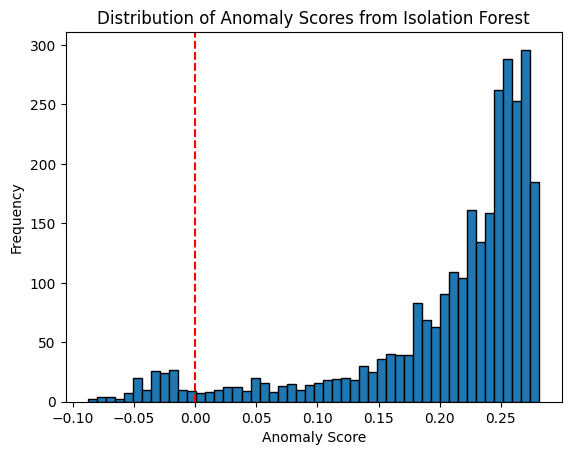

<IPython.core.display.Javascript object>

In [11]:
plt.hist(scores, bins=50, edgecolor="k")
plt.axvline(x=threshold, color="r", linestyle="--")
plt.title("Distribution of Anomaly Scores from Isolation Forest")
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.show()

Ideally, we would expect to see all medication not identified as anomaly (i.e., to the right of the red line) closer to 1. Then, we would except to see a large drop-off in each bin's frequency as we approach zero, with a second, but smaller plateau of bins to the left of the line. Indeed, we do see that a second plateau does indeed exist to the left of the line.

### Anomaly Scores by Medication

We'll now create a scatter plot containing each pair of values from the PCA-reduced dataframe and color-code each point by its corresponding anomaly score, as predicted by the Isolation Forest model.

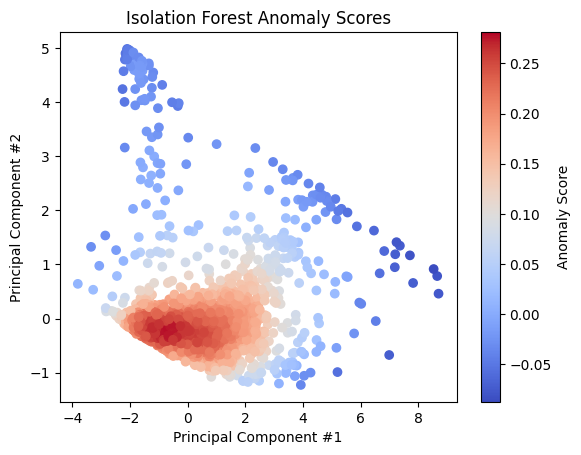

<IPython.core.display.Javascript object>

In [12]:
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=scores, cmap="coolwarm")
plt.colorbar(label="Anomaly Score")
plt.title("Isolation Forest Anomaly Scores")
plt.xlabel("Principal Component #1")
plt.ylabel("Principal Component #2")
plt.show()

It appears the Isolation Forest was effective in identifying the dense cluster of medications as non-anomalies, while also recognizing the disjoined medications and being anomalous.

In [13]:
# Create dataframe to host PCA output; anomaly predictions
pca_df = pd.DataFrame(pca_result, columns=["PCA1", "PCA2"])

# Obtain outlier labels
y_pred = clf.predict(pca_result)
pca_df["anomaly"] = y_pred

<IPython.core.display.Javascript object>

### Binary Anomaly Rating by Medication

Let's now look at another scatter plot showing the medications, but this time we'll use a binary encoding to show whether or not they were determined to be an anomaly.

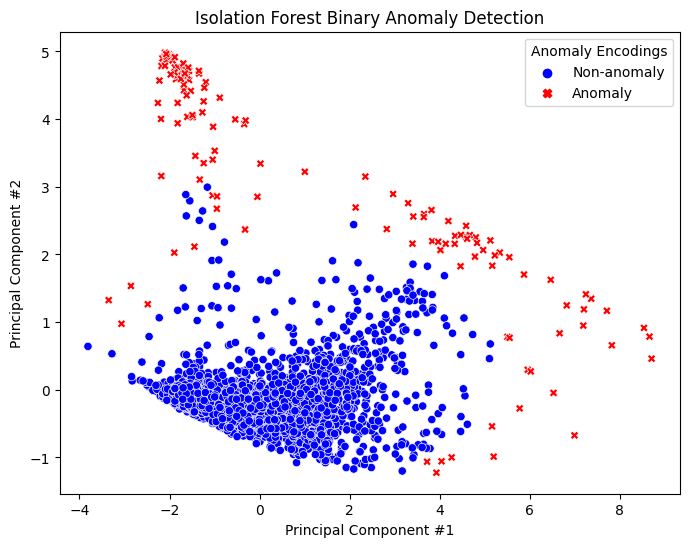

<IPython.core.display.Javascript object>

In [14]:
binary_plot_df = pca_df.copy()
binary_plot_df["anomaly"].replace({1: "Non-anomaly", -1: "Anomaly"}, inplace=True)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=binary_plot_df,
    x="PCA1",
    y="PCA2",
    hue="anomaly",
    palette={"Non-anomaly": "blue", "Anomaly": "red"},
    style="anomaly",
    markers={"Non-anomaly": "o", "Anomaly": "X"},
)
plt.title("Isolation Forest Binary Anomaly Detection")
plt.xlabel("Principal Component #1")
plt.ylabel("Principal Component #2")
plt.legend(title="Anomaly Encodings")
plt.show()

### Density Scatter Plot Amongst Non-anomaly Medications
It can be a bit hard to tell how many data points are overlapping with one another given how dense the non-anomalous data points are. Let's filer out the medications tagged as anomalies and view a density scatter plot of the residual medications.

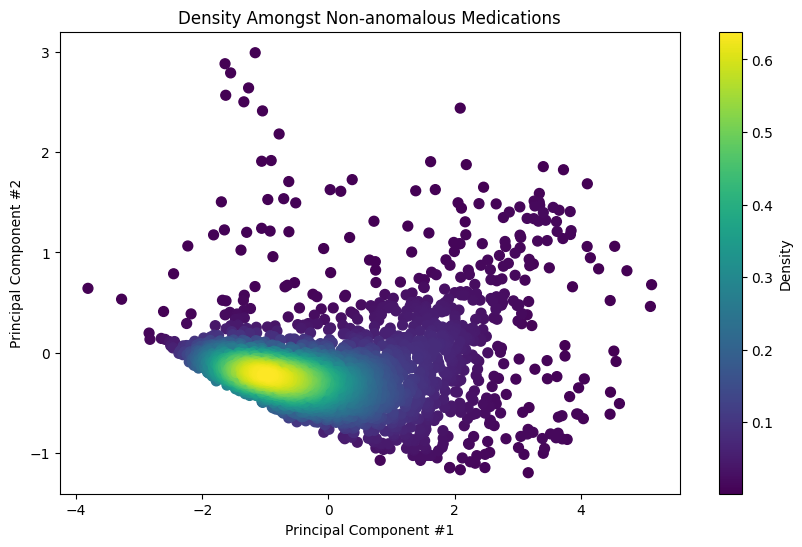

<IPython.core.display.Javascript object>

In [15]:
# Filter out anomalies and create new variables
pca_df_non_anomalies = pca_df[pca_df["anomaly"] == 1]
pca_matrix_non_anomalies = pca_df_non_anomalies.values
x = pca_matrix_non_anomalies[:, 0]
y = pca_matrix_non_anomalies[:, 1]

# Calculate the point density
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

plt.figure(figsize=(10, 6))
scatter = plt.scatter(x, y, c=z, s=50, cmap="viridis")
cbar = plt.colorbar(scatter)
cbar.set_label("Density")
plt.title("Density Amongst Non-anomalous Medications")
plt.xlabel("Principal Component #1")
plt.ylabel("Principal Component #2")
plt.show()

Let's now update `summary_df` to include the outputs from the Isolation Forest denoting whether a medication's aggregate data is an anomaly.

In [16]:
outlier_dict = {}
for med, val in zip(isof_df.index, y_pred):
    outlier_dict.update({med: val})

summary_df["anomaly"] = summary_df.apply(
    lambda row: (
        outlier_dict[row.name] if row.name in outlier_dict.keys() else row.anomaly
    ),
    axis=1,
)

summary_df["anomaly"].value_counts()

anomaly
 1.0    2713
-2.0    1737
-1.0     143
Name: count, dtype: int64

<IPython.core.display.Javascript object>

Overall, we can see that our manual tagging of anomalies resulted in 1,700+ medications being defined as anomalies. This was mostly due to the fact that  1,1,500+ medications did not have specified inventory min. / max. thresholds. Because of this, we're unable to calculate inventory KPIs, such as scarcity rate, for these medications, and thus do not want to consider them for further analysis. However, with a revised dataset that does fill in these gaps, these medications could be incorporated into a follow-up analysis.

## Exploratory Data Analysis

As a point of reference, the first summary table below shows aggregate statistics for the non-anomaly medications. The second table shows the medication-level aggregate statistics for a sample of medications that were flagged as anomalies by the Isolation Forest. Can you spot what specific feature values might have influenced the decision to classify these as outliers?

In [17]:
non_anomaly_df = summary_df[summary_df["anomaly"] == 1]

non_anomaly_df[
    [
        "mean_picks",
        "mean_inventory",
        "percent_days_w_pick",
        "coef_var",
        "days_sales_inventory",
        "excess_rate",
        "scarce_rate",
    ]
].describe()

,mean_picks,mean_inventory,percent_days_w_pick,coef_var,days_sales_inventory,excess_rate,scarce_rate
count,2713.000000,2713.000000,2713.000000,2713.000000,2713.000000,2713.000000,2713.000000
mean,15.407400,267.056669,0.365280,4.264558,107.116243,0.281715,0.214715
std,85.634748,1788.886638,0.334775,3.869022,274.283160,0.243462,0.248564
min,0.002398,0.009721,0.001901,0.195339,0.000721,0.000000,0.000000
25%,0.230769,12.476306,0.074778,1.771755,15.697080,0.077954,0.028037
50%,1.170999,53.322993,0.242092,2.954781,32.628186,0.222357,0.106926
75%,6.476306,174.027167,0.627737,5.234653,86.140898,0.432234,0.317132
max,2744.085055,55437.510328,1.000000,23.455780,4263.133333,1.000000,1.000000


<IPython.core.display.Javascript object>

In [18]:
summary_df[summary_df["anomaly"] == -1][
    [
        "mean_picks",
        "mean_inventory",
        "percent_days_w_pick",
        "coef_var",
        "days_sales_inventory",
        "excess_rate",
        "scarce_rate",
    ]
].describe().sample(5)

,mean_picks,mean_inventory,percent_days_w_pick,coef_var,days_sales_inventory,excess_rate,scarce_rate
min,0.001215,0.906494,0.001215,4.031388,0.002738,0.000000,0.000000
50%,25.630620,51.198056,0.087591,27.289914,3.488237,0.251238,0.089961
25%,0.007538,6.748662,0.002097,24.579271,0.513323,0.076478,0.015336
mean,141.140093,172.217279,0.290155,24.771171,5043.882996,0.339935,0.210771
75%,139.879323,123.642875,0.529805,28.151375,1443.271226,0.547528,0.320571


<IPython.core.display.Javascript object>

Let's also view how each of these variables correlate with one another through a SPLOM.

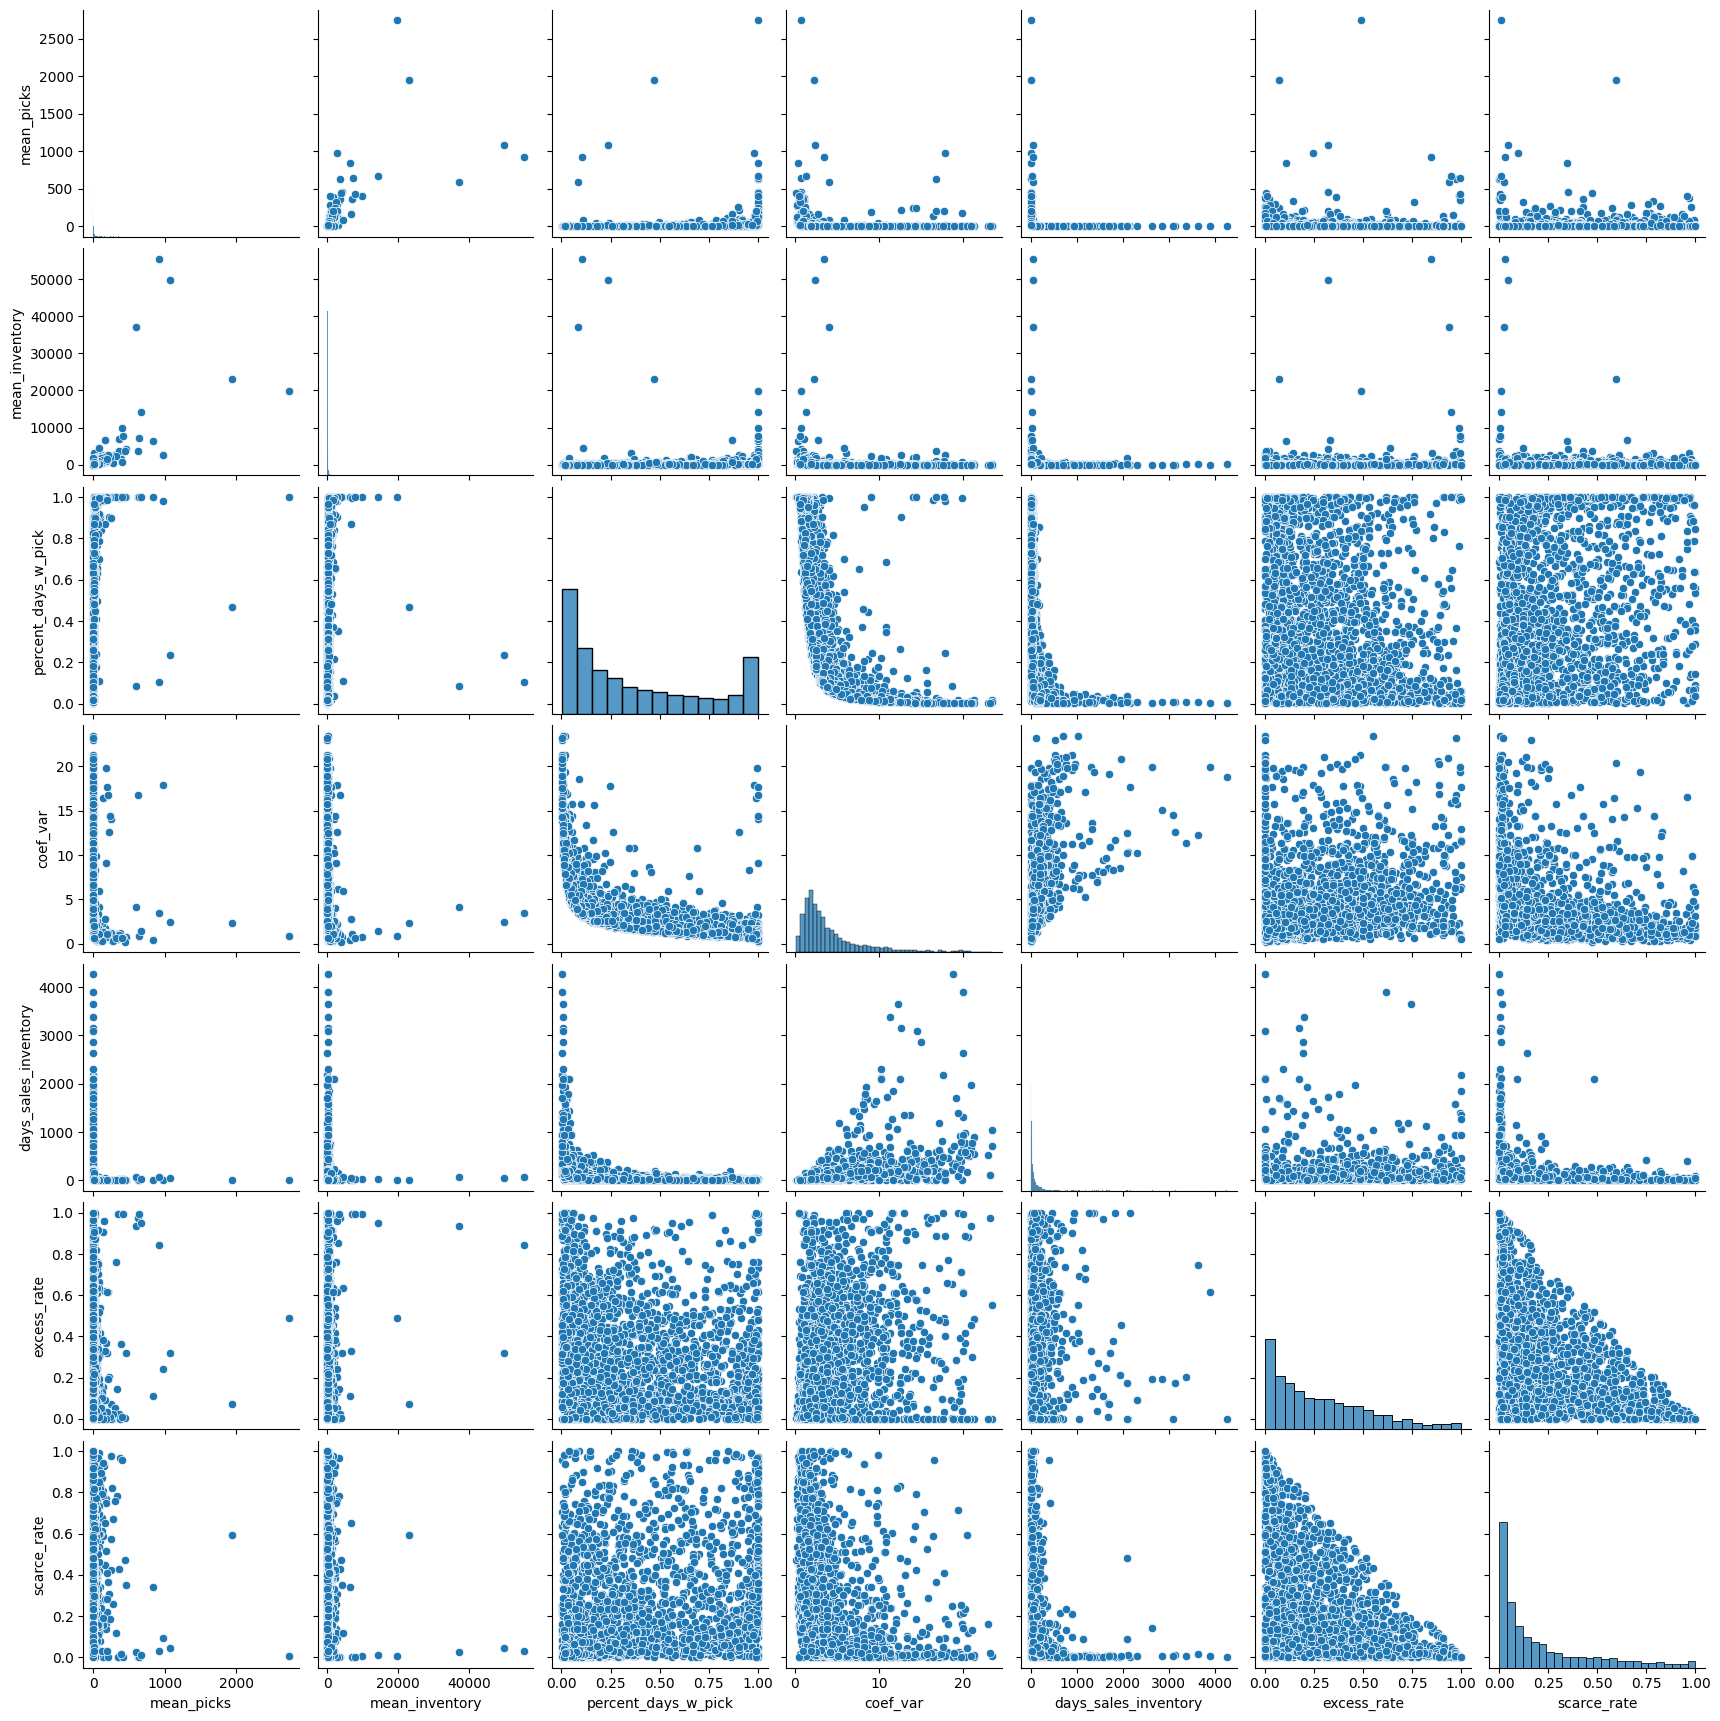

<IPython.core.display.Javascript object>

In [19]:
splom_df = non_anomaly_df[
    [
        "mean_picks",
        "mean_inventory",
        "percent_days_w_pick",
        "coef_var",
        "days_sales_inventory",
        "excess_rate",
        "scarce_rate",
    ]
]

sns.pairplot(pd.DataFrame(data=splom_df, columns=splom_df.columns))
plt.show()

## Export data
With each medication now being defined as either an anomaly, or not, let's export a new copy of the summary statistics dataframe which may be incorporated into our subsequent regression tasks.

In [20]:
summary_df.to_csv("../outputs/inventory_summary_statistics.csv", index=True)

<IPython.core.display.Javascript object>

## KMeans Clustering

### Data Preprocessing
We'll now see if we can cluster medications by various demand signals. For this analysis, we want to focus on features which represent the **volume**, **variability**, and **inventory efficiency** of each medication:
*   `mean_picks` and `mean_inventory` will represent the volume of the medication
*   `coef_var` (coefficient of variation) will represent the variability
*   `days_sales_inventory`, `scarce_rate`, and `excess_rate` will represent the average inventory on-hand.

We'll begin by reducing `cluster_df` to only the aforementioned features and the medications which the Isolation Forest identified as being non-anomalies. We'll then scale each of these features using either a standard, minmax, or logarithmic scaler based upon the distribution or range of values for each respective feature.

We'll then use PCA again to reduce the data to two features to assist with subsequent data visualization.

In [21]:
cluster_df = summary_df[summary_df["anomaly"] == 1]
cluster_df = cluster_df[
    [
        "mean_picks",
        "mean_inventory",
        "percent_days_w_pick",
        "coef_var",
        "days_sales_inventory",
        "inv_turnover_ratio",
        "excess_rate",
        "scarce_rate",
        "stockout_rate",
    ]
]

transformers = [
    ("num", StandardScaler(), ["coef_var"]),
    ("min", MinMaxScaler(), ["scarce_rate", "excess_rate"]),
    (
        "skewed",
        FunctionTransformer(np.log1p),
        ["days_sales_inventory", "mean_picks", "mean_inventory"],
    ),
]
preprocessor = ColumnTransformer(transformers)
cluster_df_scaled = preprocessor.fit_transform(cluster_df)

pca = PCA(n_components=2)
X = pca.fit_transform(cluster_df_scaled)

<IPython.core.display.Javascript object>

Now let's create a density plot to show the distribution of values, prior to building the clustering model. The data doesn't form disparate clusters even after removing anomalies and reducing the data using PCA. However, despite the single, dense cluster we see, it'd be inaccurate to say all medications closely share the same values on the selected inventory KPIs. To separate this dense cluster into subcomponents, we'll use a KMeans model.

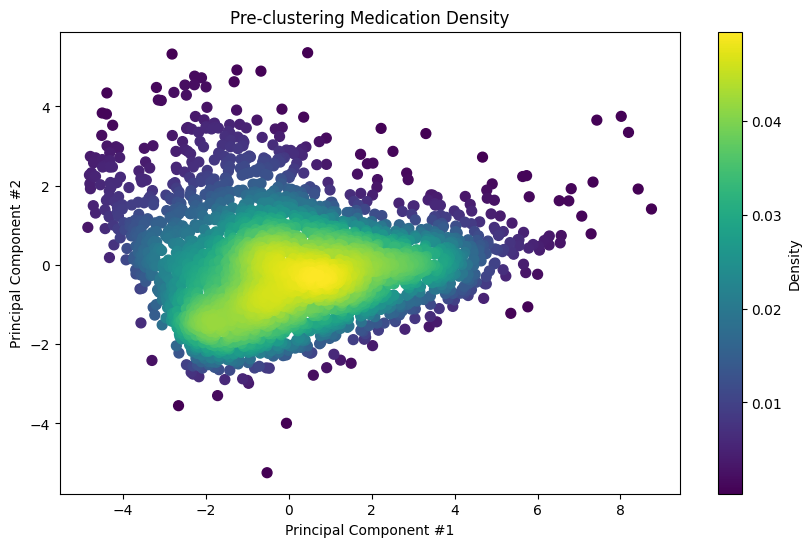

<IPython.core.display.Javascript object>

In [22]:
x = X[:, 0]
y = X[:, 1]

# Calculate the point density
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)

# Sort the points by density (densest points are plotted last)
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

plt.figure(figsize=(10, 6))
scatter = plt.scatter(x, y, c=z, s=50, cmap="viridis")
cbar = plt.colorbar(scatter)
cbar.set_label("Density")
plt.title("Pre-clustering Medication Density")
plt.xlabel("Principal Component #1")
plt.ylabel("Principal Component #2")
plt.show()

### Hyperparameter Optimization

Before executing the model, we'll want to look at the inertia and silhouette scores returned for various cluster sizes. Let's iterate through a range of 3-10 and see what those scores look like.

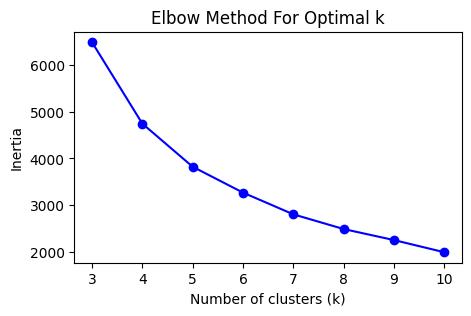

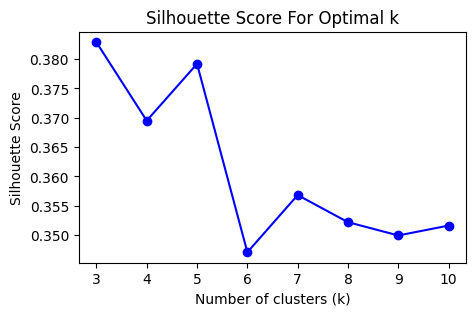

<IPython.core.display.Javascript object>

In [23]:
# Elbow Method
inertia = []
K_range = range(3, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, n_init="auto", random_state=8)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(5, 3))
plt.plot(K_range, inertia, "bo-")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method For Optimal k")
plt.show()

# Silhouette Score
silhouette_scores = []
for k in K_range:
    kmeans = KMeans(n_clusters=k, n_init="auto", random_state=8)
    kmeans.fit(X)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

plt.figure(figsize=(5, 3))
plt.plot(K_range, silhouette_scores, "bo-")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score For Optimal k")
plt.show()

So, what can we learn from these scores? In looking at the silhouette scores, we can see that the highest score is returned when `k=3`. However, clustering all medications into only three distinct categories may be a bit of an over-simplification. Afterall, from our exploratory data analysis, we know that the range of values medications can have on their inventory KPIs related to volume, variable, and inventory efficiency can vary greatly. With that in mind, it may be a better choice to go with `k=5` given its silhouette score is only marginally lower. While it may provide greater levels of specificity amongst cluster, there doesn't look to otherwise be an argument for a `k` value >5 given the relatively significant drop in silhouette scores from thereon. When evaluating the inertia scores, there doesn't look to be a drastic "elbow" shape forming, however, if anything, these scores indicate that either `k=4` or `k=5` would be a relatively stronger choice for the number of clusters.

Given the above, let's override the optimal choice for `k` to be 5.

In [24]:
# Choose the optimal number of clusters based on the previous plots
optimal_k = 5

<IPython.core.display.Javascript object>

### Model Execution

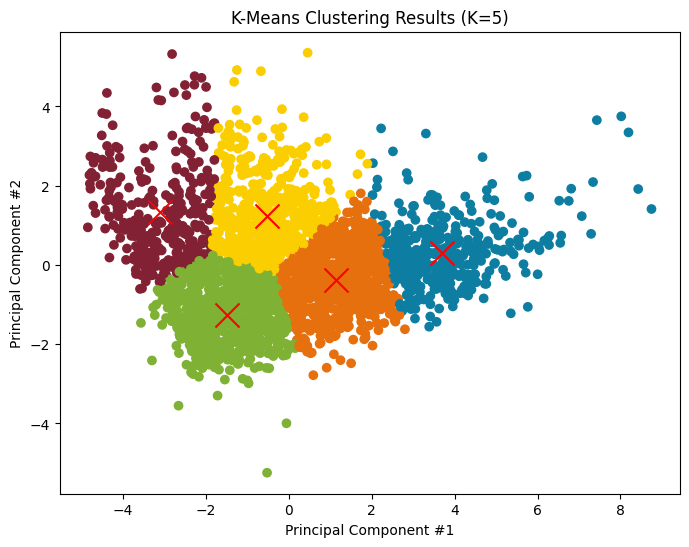

<IPython.core.display.Javascript object>

In [25]:
# Fit KMeans with optimal k
kmeans_optimal = KMeans(n_clusters=optimal_k, n_init="auto", random_state=8)
kmeans_optimal.fit(X)
labels = kmeans_optimal.labels_

custom_palette = ["#7FB135", "#0D7EA2", "#FACE00", "#E66F0E", "#822133"]
custom_cmap = mcolors.ListedColormap(custom_palette)

# Plot the resulting clusters
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap=custom_cmap, marker="o")
plt.scatter(
    kmeans_optimal.cluster_centers_[:, 0],
    kmeans_optimal.cluster_centers_[:, 1],
    s=300,
    c="red",
    marker="x",
)
plt.xlabel("Principal Component #1")
plt.ylabel("Principal Component #2")
plt.title("K-Means Clustering Results (K=5)")
plt.show()

### Model Evaluation

Let's see how many medications are found in each cluster.

In [26]:
cluster_df.loc[:, "Cluster"] = labels
cluster_df["Cluster"].value_counts()

Cluster
0    731
3    727
2    515
1    417
4    323
Name: count, dtype: int64

<IPython.core.display.Javascript object>

Now let's check out the median values for each metric for each cluster to better understand cluster characteristics.

In [27]:
median_values = (
    cluster_df.groupby("Cluster")[
        [
            "mean_picks",
            "mean_inventory",
            "percent_days_w_pick",
            "coef_var",
            "days_sales_inventory",
            "inv_turnover_ratio",
            "excess_rate",
            "scarce_rate",
            "stockout_rate",
        ]
    ]
    .median()
    .reset_index("Cluster", drop=True)
)
median_values

,mean_picks,mean_inventory,percent_days_w_pick,coef_var,days_sales_inventory,inv_turnover_ratio,excess_rate,scarce_rate,stockout_rate
0,0.358881,9.190476,0.136253,3.271515,26.356178,30.365417,0.152522,0.181931,0.010936
1,35.997570,560.678007,0.974484,1.406939,14.496825,56.278545,0.172539,0.236938,0.000000
2,0.655637,76.327839,0.112469,4.842019,111.617754,7.085388,0.392683,0.018248,0.002484
3,4.925373,101.290754,0.552439,1.853235,21.322373,38.054778,0.196841,0.154313,0.002430
4,0.026194,6.758663,0.013245,10.667009,233.722222,3.227813,0.329910,0.016049,0.005348


<IPython.core.display.Javascript object>

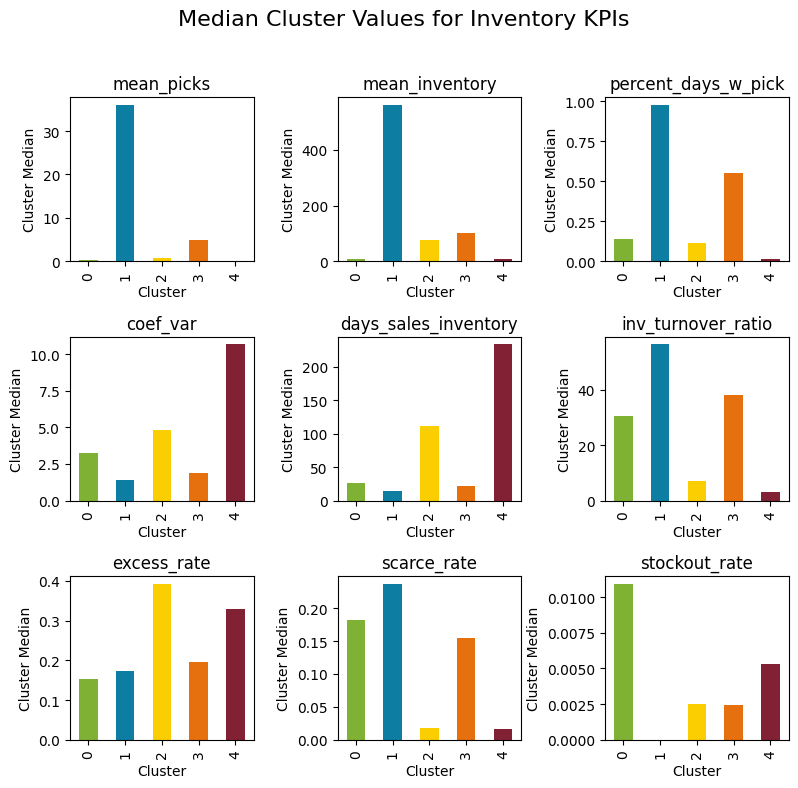

<IPython.core.display.Javascript object>

In [28]:
features = median_values.columns
n_features = len(features)

fig, axes = plt.subplots(3, 3, figsize=(8, 8))
fig.suptitle("Median Cluster Values for Inventory KPIs", fontsize=16)

axes = axes.flatten()

for i, feature in enumerate(features):
    ax = axes[i]
    median_values[feature].plot(kind="bar", ax=ax, title=feature, color=custom_palette)
    ax.set_ylabel("Cluster Median")
    ax.set_xlabel("Cluster")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Please refer to our project report document where we analyze these findings in greater detail.